In [2]:
import os
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [3]:
# Define the directory path
data_dir =r'C:\Users\satya\Downloads\cell_images\dataset2-master\dataset2-master\images\TRAIN'

# Define the class labels
class_labels = ['eosinophil', 'lymphocyte', 'monocyte', 'neutrophil']


In [4]:
# Initialize lists to hold file paths and labels
filepaths = []
labels = []

# Loop through each class directory and gather file paths and labels
for label in class_labels:
    class_dir = os.path.join(data_dir, label)
    for file in os.listdir(class_dir):
        if file.endswith('.jpeg') or file.endswith('.png'):  # Ensure file is an image
            filepaths.append(os.path.join(class_dir, file))
            labels.append(label)


In [5]:
# Create a DataFrame from the file paths and labels
bloodCell_df = pd.DataFrame({
    'filepaths': filepaths,
    'labels': labels
})

In [6]:
# Shuffle the DataFrame
bloodCell_df = bloodCell_df.sample(frac=1).reset_index(drop=True)

In [7]:
bloodCell_df.head()

,filepaths,labels
0,C:\Users\satya\Downloads\cell_images\dataset2-...,neutrophil
1,C:\Users\satya\Downloads\cell_images\dataset2-...,neutrophil
2,C:\Users\satya\Downloads\cell_images\dataset2-...,lymphocyte
3,C:\Users\satya\Downloads\cell_images\dataset2-...,neutrophil
4,C:\Users\satya\Downloads\cell_images\dataset2-...,lymphocyte


In [13]:
import matplotlib.pyplot as plt
import numpy as np

def show_knee_images(image_gen):
    test_dict = image_gen.class_indices

    classes = list(test_dict.keys())
    images, labels = next(image_gen)
    plt.figure(figsize=(20, 20))
    length = len(labels)
    if length < 25:
        r = length
    else:
        r = 25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image = (images[i] + 1) / 2
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name, color="green", fontsize=16)
        plt.axis('off')
    plt.show()



Found 9957 images belonging to 4 classes.


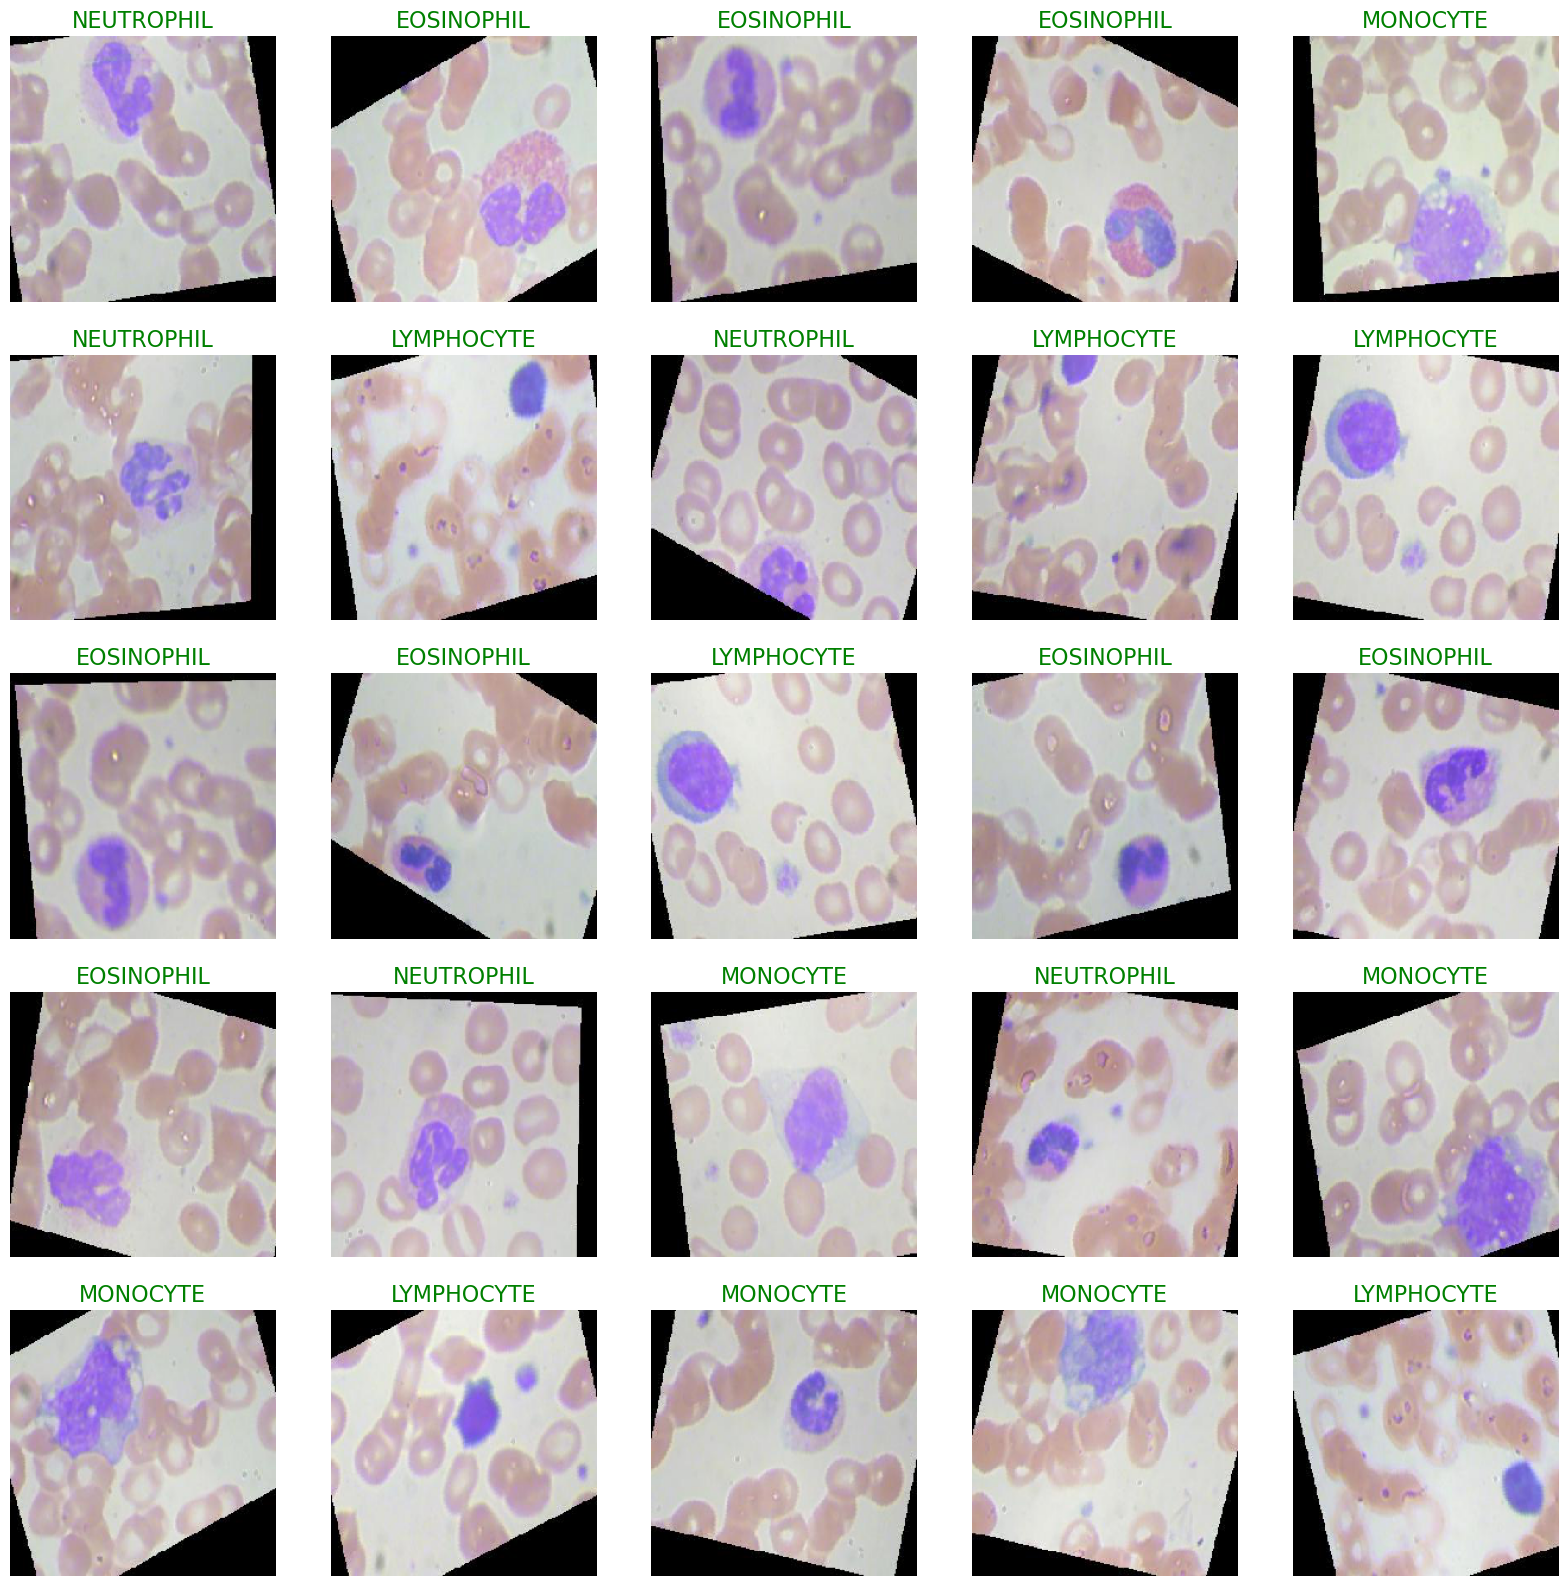

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the image generator
datagen = ImageDataGenerator(rescale=1./255)

# Load images from your dataset folder
train = datagen.flow_from_directory(
    r'C:\Users\satya\OneDrive\Documents\hematovision\static\cell_images\dataset2-master\dataset2-master\images\TRAIN',  # 🔁 Replace with your dataset path
    target_size=(224, 224),  # 🔁 Adjust if your model expects a different size
    batch_size=32,
    class_mode='categorical'  # or 'binary' for 2 classes
)

# Function to display images with labels
def show_knee_images(image_gen):
    test_dict = image_gen.class_indices
    classes = list(test_dict.keys())
    images, labels = next(image_gen)
    plt.figure(figsize=(20, 20))
    length = len(labels)
    r = length if length < 25 else 25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image = images[i]
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name, color="green", fontsize=16)
        plt.axis('off')
    plt.show()

# Show a sample batch
show_knee_images(train)


In [19]:
# Correct split flow
train_images, test_images = train_test_split(bloodCell_df, test_size=0.3, random_state=42)
train_set, val_set = train_test_split(train_images, test_size=0.2, random_state=42)  # 20% of 70% = 14%


In [20]:
print(train_set.shape)
print(test_images.shape)
print(val_set.shape)
print(train_images.shape)

(5575, 2)
(2988, 2)
(1394, 2)
(6969, 2)


In [21]:
image_gen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

train = image_gen.flow_from_dataframe(
    dataframe=train_set,
    x_col="filepaths",
    y_col="labels",
    target_size=(244, 244),
    color_mode='rgb',
    class_mode="categorical",
    batch_size=8,
    shuffle=False
)

test = image_gen.flow_from_dataframe(
    dataframe=test_images,
    x_col="filepaths",
    y_col="labels",
    target_size=(244, 244),
    color_mode='rgb',
    class_mode="categorical",
    batch_size=8,
    shuffle=False
)

val = image_gen.flow_from_dataframe(
    dataframe=val_set,
    x_col="filepaths",
    y_col="labels",
    target_size=(244, 244),
    color_mode='rgb',
    class_mode="categorical",
    batch_size=8,
    shuffle=False
)


Found 5575 validated image filenames belonging to 4 classes.
Found 2988 validated image filenames belonging to 4 classes.
Found 1394 validated image filenames belonging to 4 classes.


In [22]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=(8, 8), strides=(3, 3), activation='relu', input_shape=(224, 224, 3)),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3, 3)),

    keras.layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2, 2)),

    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2, 2)),

    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2, 2)),

    keras.layers.Flatten(),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.optimizers.SGD(learning_rate=0.001),
    metrics=['accuracy']
)

model.summary()


c:\Users\satya\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 73, 73, 128)    │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 73, 73, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 73, 73, 256)    │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 73, 73, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 24, 24, 256)    │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 24, 24, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 24, 24, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 512)      │             

 Total params: 15,610,500 (59.55 MB)

 Trainable params: 15,604,612 (59.53 MB)

 Non-trainable params: 5,888 (23.00 KB)

In [23]:
# First training session (5 epochs)
history = model.fit(train, epochs=5, validation_data=val, verbose=1)

c:\Users\satya\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
697/697 ━━━━━━━━━━━━━━━━━━━━ 2708s 4s/step - accuracy: 0.2877 - loss: 2.1771 - val_accuracy: 0.5122 - val_loss: 1.0956
Epoch 2/5
697/697 ━━━━━━━━━━━━━━━━━━━━ 3234s 5s/step - accuracy: 0.4389 - loss: 1.2444 - val_accuracy: 0.5316 - val_loss: 1.0231
Epoch 3/5
697/697 ━━━━━━━━━━━━━━━━━━━━ 29678s 43s/step - accuracy: 0.5696 - loss: 0.9745 - val_accuracy: 0.5904 - val_loss: 0.9050
Epoch 4/5
697/697 ━━━━━━━━━━━━━━━━━━━━ 1526s 2s/step - accuracy: 0.6913 - loss: 0.7249 - val_accuracy: 0.7984 - val_loss: 0.4826
Epoch 5/5
697/697 ━━━━━━━━━━━━━━━━━━━━ 1536s 2s/step - accuracy: 0.7985 - loss: 0.4945 - val_accuracy: 0.8680 - val_loss: 0.3285


In [24]:
history1 = model.fit(train, epochs=1, validation_data=val, verbose=1)

697/697 ━━━━━━━━━━━━━━━━━━━━ 1707s 2s/step - accuracy: 0.8430 - loss: 0.3683 - val_accuracy: 0.8264 - val_loss: 0.3867


In [25]:
# Predicting on the test data
pred = model.predict(test)
pred = np.argmax(pred, axis=1)  # pick class with highest probability

# Getting class labels
labels = (train.class_indices)
labels = dict((v, k) for k, v in labels.items())
pred2 = [labels[k] for k in pred]

374/374 ━━━━━━━━━━━━━━━━━━━━ 227s 603ms/step


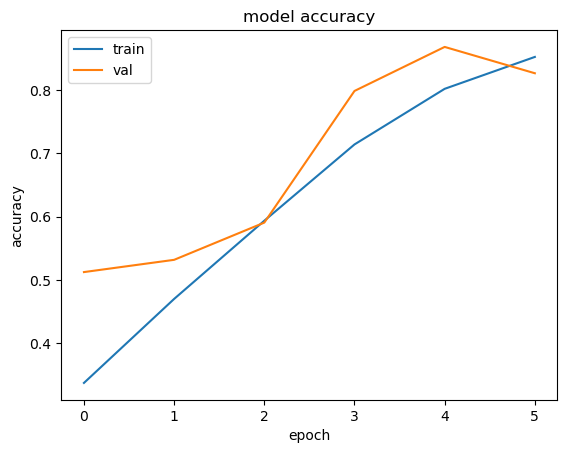

In [26]:
# Plotting model accuracy
plt.plot(history.history['accuracy'] + history1.history['accuracy'])
plt.plot(history.history['val_accuracy'] + history1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

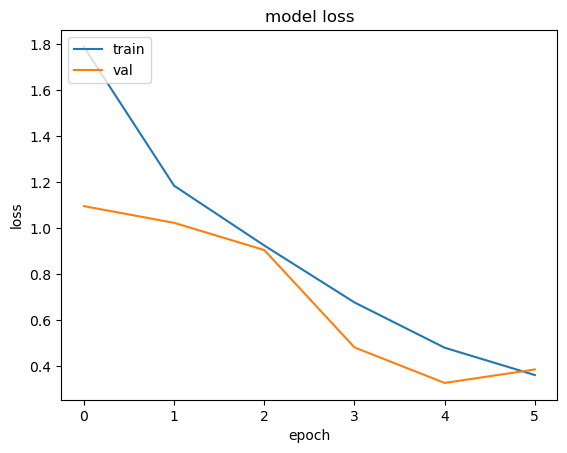

In [27]:
plt.plot(history.history['loss'] + history1.history['loss'])
plt.plot(history.history['val_loss'] + history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [28]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report

y_test = test_images.labels  # set y_test to the expected output

print(classification_report(y_test, pred2))
print("Accuracy of the Model:", "{:.1f}%".format(accuracy_score(y_test, pred2) * 100))


              precision    recall  f1-score   support

  eosinophil       0.82      0.56      0.67       756
  lymphocyte       1.00      0.91      0.95       753
    monocyte       0.99      0.93      0.96       728
  neutrophil       0.64      0.94      0.76       751

    accuracy                           0.83      2988
   macro avg       0.86      0.84      0.84      2988
weighted avg       0.86      0.83      0.83      2988

Accuracy of the Model: 83.4%


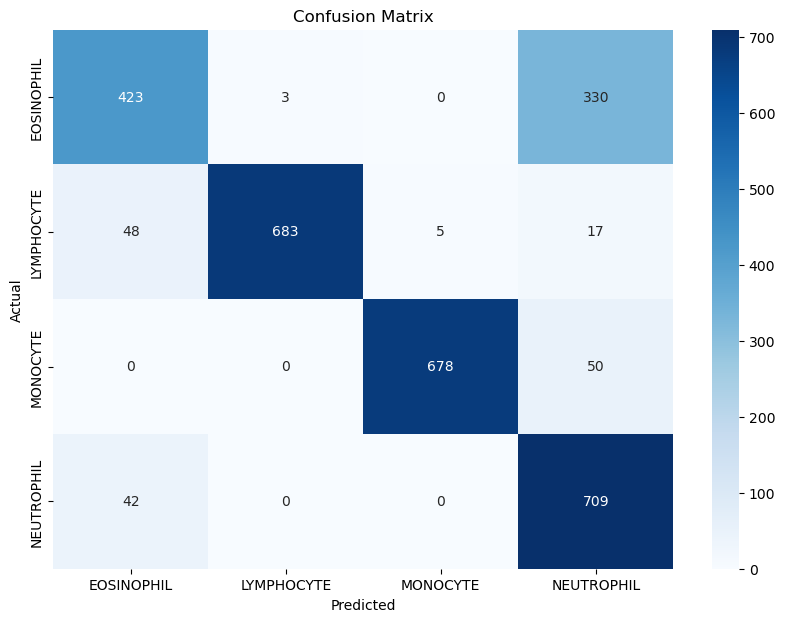

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

class_labels = ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']

cm = confusion_matrix(y_test, pred2)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues')
plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=class_labels)
plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [33]:
model.save("blood cell.h5")


In [34]:
model.save("Blood_Cell.keras")
